# Wide and Deep Model

In [16]:
%reset -f
import numpy as np
import pandas as pd
import tensorflow as tf

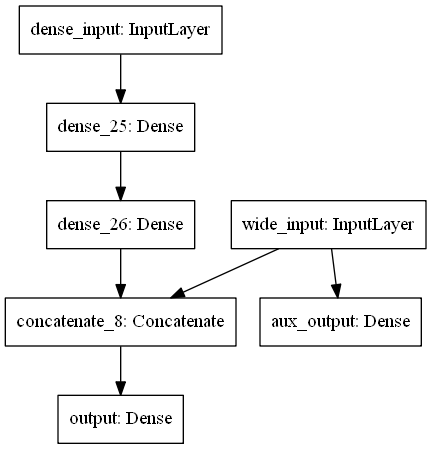

In [17]:
input_a = tf.keras.Input(shape=[1],name='wide_input')
input_b = tf.keras.Input(shape=[1],name='dense_input')

hidden_1 = tf.keras.layers.Dense(30,activation='relu')(input_b)
hidden_2 = tf.keras.layers.Dense(30,activation='relu')(hidden_1)

concat = tf.keras.layers.concatenate([hidden_2,input_a])
output = tf.keras.layers.Dense(1,name='output')(concat)

aux_output = tf.keras.layers.Dense(1,name='aux_output')(input_a)

model = tf.keras.Model(inputs=[input_a,input_b],outputs=[output,aux_output])
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model.png')
tf.keras.utils.plot_model(model)

In [15]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 30)           60          dense_input[0][0]                
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 30)           930         dense_23[0][0]                   
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 1)]          0                                            
____________________________________________________________________________________________

# Implement as a class

In [28]:
%reset -f
import numpy as np
import pandas as pd
import tensorflow as tf

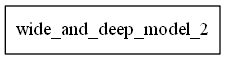

In [29]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self,units=30,activation='relu',**kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(units,activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units,activation=activation)
        self.main_output=tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self,inputs):
        input_a,input_b = inputs
        hidden1 = self.hidden1(input_b)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input_a,hidden2])
        main_output=self.main_output(concat)
        aux_output=self.aux_output(hidden2)
        
        return main_output,aux_output
    
model = WideAndDeepModel()
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model.png')
tf.keras.utils.plot_model(model)

In [40]:
input_a = np.ones(shape=(1,))
input_b = np.ones(shape=(1,))
input=input_a,input_b
model.compile(loss='mse', optimizer='sgd')
# model.fit(input_a,input_b)

In [41]:
model.summary()

Model: "wide_and_deep_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             multiple                  60        
_________________________________________________________________
dense_32 (Dense)             multiple                  930       
_________________________________________________________________
dense_33 (Dense)             multiple                  32        
_________________________________________________________________
dense_34 (Dense)             multiple                  31        
Total params: 1,053
Trainable params: 1,053
Non-trainable params: 0
_________________________________________________________________


# Custom Resnet Model

In [42]:
%reset -f
import numpy as np
import pandas as pd
import tensorflow as tf

In [43]:
class IdentityBlock(tf.keras.Model):
    def __init__(self,filters,kernel_size):
        super(IdentityBlock,self).__init__(name='')
        
        self.conv1 = tf.keras.layers.Conv2D(filters,kernel_size,padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.conv2 = tf.keras.layers.Conv2D(filters,kernel_size,padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
    def call(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.add([x,input_tensor])
        x = self.act(x)
        
        return x
        

In [44]:
class Resnet(tf.keras.Model):
    def __init__(self,num_classes):
        super(Resnet,self).__init__()
        self.conv = tf.keras.layers.Conv2D(64,7,padding='same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))
        
        self.id1a = IdentityBlock(64,3)
        self.id1b = IdentityBlock(64,3)
        
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes,activation='softmax')
        
    def call(self,inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)
        
        x = self.id1a(x)
        x = self.id1b(x)
        
        x = self.global_pool(x)
        return self.classifier(x)
        

In [47]:
def preprocess(features):
    return tf.cast(features['image'], tf.float32) / 255., features['label']

resnet = Resnet(10)
resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [49]:
import tensorflow_datasets as tfds
dataset = tfds.load('mnist', split=tfds.Split.TRAIN, data_dir='data')
dataset = dataset.map(preprocess).batch(32)

Shuffling and writing examples to data\mnist\3.0.1.incompleteVZM6IK\mnist-train.tfrecord


Shuffling and writing examples to data\mnist\3.0.1.incompleteVZM6IK\mnist-test.tfrecord


Dataset mnist downloaded and prepared to data\mnist\3.0.1. Subsequent calls will reuse this data.


In [50]:
resnet.fit(dataset, epochs=1)

1875/1875 [==============================] - 477s 254ms/step - loss: 0.1410 - accuracy: 0.9642


# Custom VGG Network

In [3]:
# !pip install tensorflow-datasets

In [4]:
%reset -f
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
# Please uncomment all lines in this cell and replace those marked with `# YOUR CODE HERE`.
# You can select all lines in this code cell with Ctrl+A (Windows/Linux) or Cmd+A (Mac), then press Ctrl+/ (Windows/Linux) or Cmd+/ (Mac) to uncomment.



class Block(tf.keras.Model):
    def __init__(self, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions
        
        # Define a conv2D_0, conv2D_1, etc based on the number of repetitions
        for i in range(repetitions):
            
            # Define a Conv2D layer, specifying filters, kernel_size, activation and padding.
            vars(self)[f'conv2D_{i}'] = tf.keras.layers.Conv2D(filters,kernel_size,
                                                               activation='relu',
                                                               padding='same')
        
        # Define the max pool layer that will be added after the Conv2D blocks
#         self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(pool_size, pool_size),strides=(strides,strides))    
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=pool_size,strides=strides) 
  
    def call(self, inputs):
        # access the class's conv2D_0 layer
        conv2D_0 = self.conv2D_0
        
        # Connect the conv2D_0 layer to inputs
        x = conv2D_0(inputs)

        # for the remaining conv2D_i layers from 1 to `repetitions` they will be connected to the previous layer
        for i in range(1,self.repetitions):
            # access conv2D_i by formatting the integer `i`. (hint: check how these were saved using `vars()` earlier)
            conv2D_i = vars(self)[f'conv2D_{i}']
            
            # Use the conv2D_i and connect it to the previous layer
            x = conv2D_i(x)

        # Finally, add the max_pool layer
        max_pool = self.max_pool
        
        return max_pool

In [6]:
# Please uncomment all lines in this cell and replace those marked with `# YOUR CODE HERE`.
# You can select all lines in this code cell with Ctrl+A (Windows/Linux) or Cmd+A (Mac), then press Ctrl+/ (Windows/Linux) or Cmd+/ (Mac) to uncomment.



class MyVGG(tf.keras.Model):

    def __init__(self, num_classes):
        super(MyVGG, self).__init__()

        # Creating blocks of VGG with the following 
        # (filters, kernel_size, repetitions) configurations
        self.block_a = Block(64,3,2)
        self.block_b = Block(128,3,2)
        self.block_c = Block(256,3,3)
        self.block_d = Block(512,3,3)
        self.block_e = Block(512,3,3)

        # Classification head
        # Define a Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        # Create a Dense layer with 256 units and ReLU as the activation function
        self.fc = tf.keras.layers.Dense(256,activation='relu')
        # Finally add the softmax classifier using a Dense layer
        self.classifier = tf.keras.layers.Dense(num_classes,activation='softmax')

    def call(self, inputs):
        # Chain all the layers one after the other
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.classifier(x)
        return x

In [7]:
dataset = tfds.load('cats_vs_dogs', split=tfds.Split.TRAIN, data_dir='data')

# Initialize VGG with the number of classes 
vgg = MyVGG(num_classes=2)

# Compile with losses and metrics
vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define preprocessing function
def preprocess(features):
    # Resize and normalize
    image = tf.image.resize(features['image'], (224, 224))
    return tf.cast(image, tf.float32) / 255., features['label']

# Apply transformations to dataset
dataset = dataset.map(preprocess).batch(32)

# Train the custom VGG model
vgg.fit(dataset, epochs=10)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to data\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.
Epoch 1/10


TypeError: in user code:

    c:\users\eaikmmu\miniconda3\envs\adv_dl\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-6-7cfba4073a72>:30 call  *
        x = self.block_b(x)
    <ipython-input-5-009ac1760a07>:30 call  *
        x = conv2D_0(inputs)
    c:\users\eaikmmu\miniconda3\envs\adv_dl\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\eaikmmu\miniconda3\envs\adv_dl\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:201 assert_input_compatibility
        raise TypeError('Inputs to a layer should be tensors. Got: %s' % (x,))

    TypeError: Inputs to a layer should be tensors. Got: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F0E542F6D8>
